# Tensorboard Introduction

Welcome to the introduction of [`TensorBoard`](https://www.tensorflow.org/tensorboard). In this tutorial, we’ll learn how to:

1. Set up TensorBoard
2. Write values to TensorBoard
3. Inspect a model architecture using TensorBoard
4. Train model and write loss, accuracy and some images to TensorBoard

Finally we will visualize the effect of different weight initializations on the neural network using `TensorBoard`.

## (Optional) Mount folder in Colab

Uncomment thefollowing cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_07'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

In [ ]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
# !python -m pip install torchtext==0.12.0 torchaudio==0.11.0

# 1. Getting Started

TensorBoard helps us track our metrics such as loss, accuracy and visualize the results, model graphs that may be needed during the machine learning workflow. 

Let's start by installing `TensorBoard` and maybe the correct alternative libraries for google colab.

In [1]:
# remove the "> /dev/null" if you want to see the output of installation statu
import sys

# For google colab
# !python -m pip install tensorboard==2.9.1 > /dev/null

# For anaconda/regular environments
# !{sys.executable} -m pip install tensorboard==2.9.1

In [3]:
import tensorboard
import torch
import torchvision
print(f"Tensorboard version: {tensorboard.__version__}")
if not tensorboard.__version__.startswith("2.9.1"):
    print("You are using an another version of Tensorboard. We expect Tensorboard 2.9.1 You may continue using your version but it"
          " might cause dependency and compatibility issues.")
print(f"PyTorch version Installed: {torch.__version__}\nTorchvision version Installed: {torchvision.__version__}\n")
if not torch.__version__.startswith("1.11"):
    print("you are using an another version of PyTorch. We expect PyTorch 1.11.0. You may continue using your version but it"
          " might cause dependency and compatibility issues.")
if not torchvision.__version__.startswith("0.12"):
    print("you are using an another version of torchvision. We expect torchvision 0.12. You can continue with your version but it"
          " might cause dependency and compatibility issues.")

Tensorboard version: 2.11.0
You are using an another version of Tensorboard. We expect Tensorboard 2.9.1 You may continue using your version but it might cause dependency and compatibility issues.
PyTorch version Installed: 1.13.0+cu117
Torchvision version Installed: 0.14.0+cu117

you are using an another version of PyTorch. We expect PyTorch 1.11.0. You may continue using your version but it might cause dependency and compatibility issues.
you are using an another version of torchvision. We expect torchvision 0.12. You can continue with your version but it might cause dependency and compatibility issues.


This tutorial is highly aligned with the `TensorBoard` tutorial from [`PyTorch`](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html). Have a look at that tutorial as well!

## 2. Setting up  TensorBoard

Let's start from where we ended the previous notebook on `PyTorch`. We will again use the [`Fashion-MNIST`](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset for this notebook.

The below cell of code sets up the dataloader and a plotting function to visualize samples from the dataset. This step is very similar to our previous notebook.

In [4]:
# import all the required packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])  # mean and std have to be sequences (e.g. tuples),
                                                                      # therefore we should add a comma after the values

fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root='../datasets', train=True,
                                                          download=True, transform=transform)

fashion_mnist_test_dataset = torchvision.datasets.FashionMNIST(root='../datasets', train=False,
                                                          download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(fashion_mnist_dataset, batch_size=8)

testloader = torch.utils.data.DataLoader(fashion_mnist_test_dataset, batch_size=8)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.cpu().mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Always remember to initialize the `device` variable with CUDA enabled GPU, in case it is available. This makes porting of our code to GPU's easier later.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the device",device)

Using the device cuda:0


Let us now intialize a 2-layer neural network model using the `nn.Module` of PyTorch. The model is then moved to the device specified by the `device` variable. We also complete the definitions of the loss function and the optimizer.

In [6]:
class Net(nn.Module):
    def __init__(self, activation=nn.Sigmoid(),
                 input_size=1*28*28, hidden_size=100, classes=10):
        super(Net, self).__init__()
        self.input_size = input_size

        # Here we initialize our activation and set up our two linear layers
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x
    
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

PyTorch provides support for logging data to TensorBoard using the `SummaryWriter` module.
We will now initialize an object of`SummaryWriter` and specify the directory [**runs/introduction**] to store its related data.

In [9]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/introduction')

# 3. Writing to TensorBoard

Let's write some stuff to TensorBoard, and log into it to see how things go. :)


1. You can open the TensorBoard GUI by running the command from this exercise folder in a Terminal:
```tensorboard --logdir=runs```

For those using Linux or Mac, you can open a Terminal **in this exercise folder** and run the above command.

For those using Windows with Anaconda packages, open an Anaconda Prompt and then run the above command. 
In case you don't  use Anaconda, use your default method of running python code in cmd.




![tensorBoard Terminal](./images/tb_terminal.png)


You must be able to see the URL link (  `http://localhost:6006/` in the image) for accessing the tensorboard interface. Let's navigate to that URL in a browser.


2) Also, if you're using VScode, press <code> Ctrl + Shift + p (Windows User), CMD + Shift + P (Mac User)</code> and look for <code> Tensorboard </code> (Make sure that version <code>2.8.0</code> is installed)

![](./images/Vscode_tensorboard.png)
![](./images/Vscode_tensorboard_2.png)

If your log file is too big, the loading process may exceed the timeout of the Python plug-in. In that case you should launch tensorboard in a Terminal.

3) If you are using Google Colab, run the uncommented following cell to load the TensorBoard extension within the notebook.
You may have to scroll to this block whenever you need to look at the tensorboard interface.

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir runs


No dashboards are created yet! Let's log some data to our `SummaryWriter` object

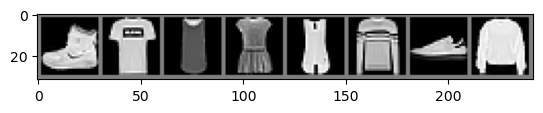

In [12]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images using our helper function
matplotlib_imshow(img_grid)

# Write the generated image to tensorboard
writer.add_image('four_mnist_images', img_grid)

We can now see the image in our TensorBoard interface.  You might need to hit the refresh button on the top right as TensorBoard will only update in discrete intervals of time.

![tensorBoard Interface](./images/imgvis.jpg)


# 4. Visualization Model Architectures

Let's try to now visualize the architecture of our `net` model in Tensorboard. We can even look at input and output dimensions of your model. It is also a good way to debug as the model grows more and more complex.  

Let's visualize the model now.


In [13]:
writer.add_graph(net.cpu(), images)
writer.close()

![Model Architecture Visualization](./images/tb_model.png)


Click the `GRAPHS` section in the top ribbon to access it the architecture. The above image was generated by clicking on our network `Net`.
Feel free to explore with the various features of this model's visualization! 

# 5. Training network models 

It's now time to explore the most important use of TensorBoard - for model training.


We shall define two helper functions here: `images_to_probs` and `plot_classes_preds`.

In [14]:
def images_to_probs(net, images):
    '''
    Returns the predicted class and probabilites of the image belonging to each of the classes 
    from the network output
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Returns a plot using the network, along with images
    and labels from a batch, that shows the network's class prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function defined above.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(4,4))
    
    for idx in np.arange(4):
        ax = fig.add_subplot(4, 1, idx+1, xticks=[], yticks=[])
        fig.tight_layout()
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"),loc="center",pad=5,fontsize="medium")
    return fig

We are all set up to train the model! Let's use the same framework we used in the `PyTorch` tutorial notebook.

Let's write the average loss and the plot generated from `plot_classes_preds` to TensorBoard every 1000 batches  using the `add_scalar` and `add_figure` functions. 



In [15]:
epochs = 1
running_loss = 0.0
net.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader, 0):#Iterating through the minibatches of the data

        # data is a tuple of (inputs, labels)
        inputs, labels = data
        
        # Makes sure that the model and the data are in the same device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Reset the parameter gradients for the current  minibatch iteration 
        optimizer.zero_grad()

        
        outputs = net(inputs)              # Perform a forward pass on the network with inputs
        loss = criterion(outputs, labels)  # calculate the loss with the network predictions and ground Truth
        loss.backward()                    # Perform a backward pass to calculate the gradients
        optimizer.step()                   # Optimise the network parameters with calculated gradients

        # Accumulate the loss
        running_loss += loss.item()
        
        if i % 1000 == 999:    # every thousandth mini-batch
            print("[Epoch %d, Iteration %5d]" % (epoch+1, i+1))

            # log the running loss
            writer.add_scalar('Training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # log the plot showing the model's predictions on a  sample of mini-batch using our helper function
            
            writer.add_figure('Predictions vs Actuals',
                            plot_classes_preds(net, inputs, labels),
                            i)
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Iteration  1000]
[Epoch 1, Iteration  2000]
[Epoch 1, Iteration  3000]
[Epoch 1, Iteration  4000]
[Epoch 1, Iteration  5000]
[Epoch 1, Iteration  6000]
[Epoch 1, Iteration  7000]
Finished Training


You will now be able to see the plot of loss under `SCALARS` tab. We can also see the  figure for predicted samples in `IMAGES` tab.

![](./images/tb_results1.png)

![](./images/tb_results3.png)

# 6. Experimenting  weight initialization strategies

We will now  apply all the techniques we have learned in `TensorBoard` to explore the effect of different weight initializations. In the previous exercises, we used a naive Gaussian initialization, though in the lectures you learned that one needs to be careful about the weight initialization values. In addition, weight initialization is dependent on the activation function used.  

Let's replicate those experiments!

The code below initializes a new `SummaryWriter` instance to log experiment values in the directory `weight_init_experiments`.

In [16]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/weight_init_experiments')

Let's define a test network for the experiment and keep track of the output of each layer to find how the input data is modified through the layers.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, activation_method):
        super(Net, self).__init__()
        
        self.x1 = torch.Tensor([])
        self.x2 = torch.Tensor([])
        self.x3 = torch.Tensor([])
        self.x4 = torch.Tensor([])
        self.x5 = torch.Tensor([])
        self.x6 = torch.Tensor([])
                
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 300)
        self.fc4 = nn.Linear(300, 300)
        self.fc5 = nn.Linear(300, 300)
        self.fc6 = nn.Linear(300, 300)
        self.fc7 = nn.Linear(300, 10)
        
        if activation_method == "relu" :
            self.activation = nn.ReLU() 
        elif activation_method == "tanh":
            self.activation = nn.Tanh() 
        
    def forward(self, x):
        x = x.reshape(-1,28*28)
        self.x1 = self.activation(self.fc1(x))
        self.x2 = self.activation(self.fc2(self.x1))
        self.x3 = self.activation(self.fc3(self.x2))
        self.x4 = self.activation(self.fc4(self.x3))
        self.x5 = self.activation(self.fc5(self.x4))
        self.x6 = self.activation(self.fc6(self.x5))
        logits = self.fc7 (self.x6)
        return logits

    def collect_layer_out (self):# Return the output values for each of the network layers
        return [self.x1, self.x2, self.x3, self.x4, self.x5, self.x6]
 
net = Net("tanh")

Let's now sample a batch of images for input to the network.

In [19]:
visloader = torch.utils.data.DataLoader(fashion_mnist_dataset, batch_size=40, shuffle=True)
dataiter = iter(visloader)
images, labels = next(dataiter)

print("Size of the Mini-batch input:",images.size())

Size of the Mini-batch input: torch.Size([40, 1, 28, 28])


We will plot the histogram of activation values  produced in each of the network layers as the input passes through the network model using the `add_histogram` function. This helps us look at the distribution of activation values. Select the `HISTOGRAMS` tab in TensorBoard to visualise the experiment results.

Run the uncommented code block only if you are using Google Colab

In [22]:
# %tensorboard --logdir runs

UsageError: Line magic function `%tensorboard` not found.


## 6.1 Constant weight initialization with $tanh$ activation

Let's start with constant weight initialization. What problems do you observe with the distribution of the output of each layer? 

In [23]:
net_const = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.constant_(m.weight,2.0)
        m.bias.data.fill_(0.01)
        
net_const.apply(init_weights)
outputs = net_const(images)
layer_out = net_const.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('constant_init', x, i+1)

We can see that initialization with constant values does not break the symmetry of weights, i.e. all neurons in network always learn the same features from the input since the weights are the same.  

Now we will try random weight initialization and let's see what happens if weights are initialized with high numerical values or very low numerical values.

## 6.2 Random weight initialization of small numerical values with $tanh$ activation

In [24]:
net_small_normal = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0.0, std=0.01)
        m.bias.data.fill_(0.01)
        
net_small_normal.apply(init_weights)
outputs = net_small_normal(images)
layer_out = net_small_normal.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('small_normal_tanh', x, i+1)

## 6.3  Random weight initialization of large numerical values with $tanh$ activation

In [25]:
net_large_normal = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0.0, std=0.2)
        m.bias.data.fill_(0.01)
        
net_large_normal.apply(init_weights)
outputs = net_large_normal(images)
layer_out = net_large_normal.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('large_normal_tanh', x, i+1)

From last two examples, we can see that random weight initialization with normal distribution might work well in some shallow layers of the network, while if we are going deeper into the network, it will end up with **vanishing gradient problem**, i.e.

- If weights are initialized with very high values, the term $Xw+b$ becomes significantly higher and with activation function such as $tanh$, the function returns value very close to $-1$ or $1$. At these values, the gradient of $tanh$ is very low, thus learning takes a lot of time.

- If weights are initialized with low values, it gets mapped to around 0, and the small values will kill gradients when backpropagating through the network. 


## 6.4 Xavier initialization with $tanh$ activation

From the previous examples, we can see that a proper weight initialization is needed to ensure nice distribution of the output of each layers. Here comes the **Xavier Initialization**.

We will fill the weight with values using a normal distribution $\mathcal{N}(0,{\sigma}^2)$ where

$$ \sigma = gain \times \sqrt{\frac{2}{fan _{in} + fan_{out}}} $$

Here $fan _{in}$ and $ fan_{out} $ are number of neurons in the input and output layer and ${gain}$ is a optional scaling factor.

In [26]:
net_xavier = Net("tanh")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)
        
net_xavier.apply(init_weights)
outputs = net_xavier(images)
layer_out = net_xavier.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('xavier_tanh', x, i+1)

## 6.5 Xavier initialization with ReLU

Xavier initialization requires a zero centered activation function such as $tanh$ to work well. Let's try using the Xavier initialization with ReLU:

In [ ]:
net_xavier_relu = Net("relu")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
net_xavier_relu.apply(init_weights)
outputs = net_xavier_relu(images)
layer_out = net_xavier_relu.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('xavier_relu', x, i+1)

We can see here that layer outputs collapse to zero again if we use non-zero centered activation such as ReLU.

## 6.6 He initialization with ReLU

**He Initialization** comes to our rescue for non-centered activation functions. We will fill the weight with values using a normal distribution $\mathcal{N}(0,\sigma^2)$ where

$$ \sigma = \frac {gain} {\sqrt{fan_{mode}}} $$

Here $fan _{mode}$ can be chosen either $fan _{in}$ (default) or $fan _{out}$.

Choosing $fan _{in}$ preserves the magnitude of the variance of the weights in the forward pass. Choosing $fan _{out}$ preserves the magnitudes of weights during the backwards pass. The variable $gain$ is again the optional scaling factor.

In [27]:
net_kaiming_relu = Net("relu")

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight,nonlinearity='relu')
        m.bias.data.fill_(0.01)
        
net_kaiming_relu.apply(init_weights)
outputs = net_kaiming_relu(images)
layer_out = net_kaiming_relu.collect_layer_out()

for i, x in enumerate(layer_out):
    writer.add_histogram('kaiming_relu', x, i+1)

With these, you should have everything at hand to work with Tensorboard. It is highly advised to use either Tensorboard or other similar libraries, such as visdom to visualise network training results.


We will now move to the final notebook on [`PyTorchLightning`](https://www.pytorchlightning.ai/), a wrapper for `PyTorch` which makes training neural networks more swifter and easier.
